In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from categories import *

# Исправление ссылок в первом файле

In [2]:
df = pd.read_csv('data/base/publications_page_1.csv')
df.head(5)

,Название,Ссылка на статью,Авторы,Цитирования
0,ENERGY VALUE CHAIN AND ECONOMIC IMPACT: ASSESS...,https://elibrary.ru/item.asp?id=80386839,"Zhou J., Abbas A., Vasbieva D.G.",0
1,NaN,https://elibrary.rujavascript:url_article(7960...,"Mikeš J., Stepanov S.E., Tsyganok I.I.",0
2,NaN,https://elibrary.rujavascript:url_article(7993...,"Krechko O., Mikhaylov A.",2
3,NaN,https://elibrary.rujavascript:url_article(8168...,"Mikhaylov A., Yousif N.B.A., Dincer H., Yüksel...",1
4,NaN,https://elibrary.rujavascript:url_article(8272...,"Mikheev P.V., Lebedev A.K., Borisova L.R.",0


In [ ]:
def fix_func(x):
    start_index = x.find('(')
    if start_index != -1:
        return 'https://elibrary.ru/item.asp?id=' + x[start_index + 1: start_index + 9]
    return x

df['Ссылка на статью'] = df['Ссылка на статью'].apply(fix_func)
df.to_csv('data/publications_page_1.csv', index=False)

# Обработка данных

### Формирования общего датасета

In [3]:
# функция для получения eLIBRARY ID из ссылки на статью
def ela_id(link):
    start_index = link.find('=')
    if start_index !=1:
        return int(link[start_index + 1: start_index + 9])
    
# функция для объединения датафреймов из нескольких csv файлов
def df_concat(path, start_n, end_n):
    df = pd.read_csv(f'{path}{start_n}.csv')
    for i in range(start_n + 1, end_n):
        df2 = pd.read_csv(f'{path}{i}.csv')
        df = pd.concat([df, df2], ignore_index=True)
    return df

In [ ]:
start_n = 2
end_n = 17

path_base = 'data/base/publications_page_'
df_base = df_concat(path_base, start_n, end_n)
duplicates = df_base["Ссылка на статью"].duplicated(keep=False)
print("Число дубликатов в df_base:", duplicates.sum())
df_base = df_base.drop_duplicates()
df_base['eLIBRARY ID'] = df_base['Ссылка на статью'].apply(ela_id)

path_juornals = 'data/journals/journals_page_'
df_journals = df_concat(path_juornals, start_n, end_n)

path_articles = 'data/articles/articles_page_'
df_articles = df_concat(path_articles, start_n, end_n)

# для журналов объединяем файлы, добавляем столбец eLIBRARY ID, переименовываем столбец "Название", удаляем столбец DOI и Ссылка на статью
df_journals['eLIBRARY ID'] = df_journals['Ссылка на статью'].apply(ela_id)
df_journals.rename(columns={'Название': 'Название журнала'}, inplace=True)
df_journals.drop(columns=['DOI', 'Ссылка на статью'], inplace=True)

# соединяем, удаляем дубли 
df_articles = df_articles.merge(df_journals, on=["eLIBRARY ID"])
duplicates = df_articles["Ссылка на статью"].duplicated(keep=False)
df_articles = df_articles.drop_duplicates()

# добавляем цитирования
df_articles = df_articles.merge(df_base[['eLIBRARY ID', 'Цитирования']], on=["eLIBRARY ID"], how='left')
df_articles.to_csv(f'data/articles_full_{start_n}_{end_n - 1}.csv', index=False)

print(f'Размер подробного датафрейма: {df_articles.shape}')
print(f'Размер первичного датафрейма: {df_base.shape}')

Число дубликатов в df_base: 26
Размер подробного датафрейма: (1485, 20)
Размер первичного датафрейма: (1487, 5)


In [5]:
data = pd.read_csv(f'data/all_clean.csv')
data = data[['eLIBRARY ID', 'year']]
df = pd.read_csv(f'data/articles_full_{start_n}_{end_n - 1}.csv')
df = df.merge(data[['eLIBRARY ID', 'year']], on='eLIBRARY ID', how='left', suffixes=('', '_new'))
df['year'] = df['year'].fillna(df['year_new'])
df.drop(columns=['year_new'], inplace=True)
df.loc[df['year'].isna(), 'year'] = 2025
df.drop_duplicates(inplace=True)
df.to_csv(f'data/articles_full_{start_n}_{end_n - 1}.csv', index=False)

### EDA

In [2]:
df = pd.read_csv(f'data/articles_full_2_16.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ссылка на статью     1485 non-null   object 
 1   DOI                  1343 non-null   object 
 2   eLIBRARY ID          1485 non-null   int64  
 3   article_type         1485 non-null   object 
 4   year                 1485 non-null   float64
 5   language             1485 non-null   object 
 6   title_en             1459 non-null   object 
 7   key_words_en         1466 non-null   object 
 8   abstract_en          1405 non-null   object 
 9   authors_metadata_en  1485 non-null   object 
 10  title_ru             580 non-null    object 
 11  key_words_ru         580 non-null    object 
 12  abstract_ru          562 non-null    object 
 13  authors_metadata_ru  580 non-null    object 
 14  OECD                 1485 non-null   object 
 15  Название журнала     1196 non-null   o

#### Тип публикации

In [3]:
df['article_type'].value_counts()

article_type
статья в журнале - научная статья           1161
статья в сборнике трудов конференции         245
статья в сборнике статей                      40
статья в журнале - краткое сообщение          11
статья в журнале - обзорная статья            10
статья в журнале - рецензия                    5
статья в журнале - материалы конференции       5
глава в книге                                  4
статья в журнале - разное                      2
статья в журнале - персоналия                  1
статья в журнале - редакторская заметка        1
Name: count, dtype: int64

#### Язык

In [4]:
# вручную исправляем языки для некоторых статей
# df[df['language'] == 'не определен']
spain_ids = [81516488, 68080647, 68080963, 62384591, 62242494]
df.loc[df['eLIBRARY ID'].isin(spain_ids), 'language'] = 'испанский'
df.loc[df['language'] == 'не определен', 'language'] = 'английский'

df.language.value_counts()

language
английский             900
русский                548
русский, английский     27
испанский                8
французский              1
португальский            1
Name: count, dtype: int64

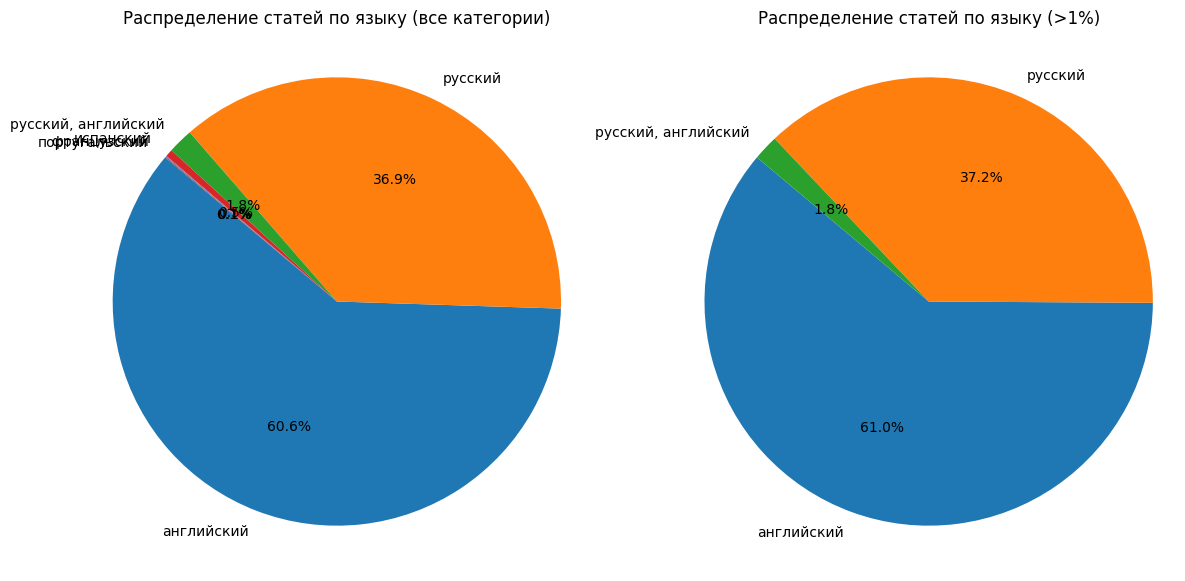

In [5]:
lang_counts = df['language'].dropna().value_counts()

total = lang_counts.sum()
filtered_counts = lang_counts[lang_counts / total >= 0.01]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Распределение статей по языку (все категории)')
axes[0].axis('equal')

axes[1].pie(filtered_counts, labels=filtered_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Распределение статей по языку (>1%)')
axes[1].axis('equal')

plt.show()


#### Год

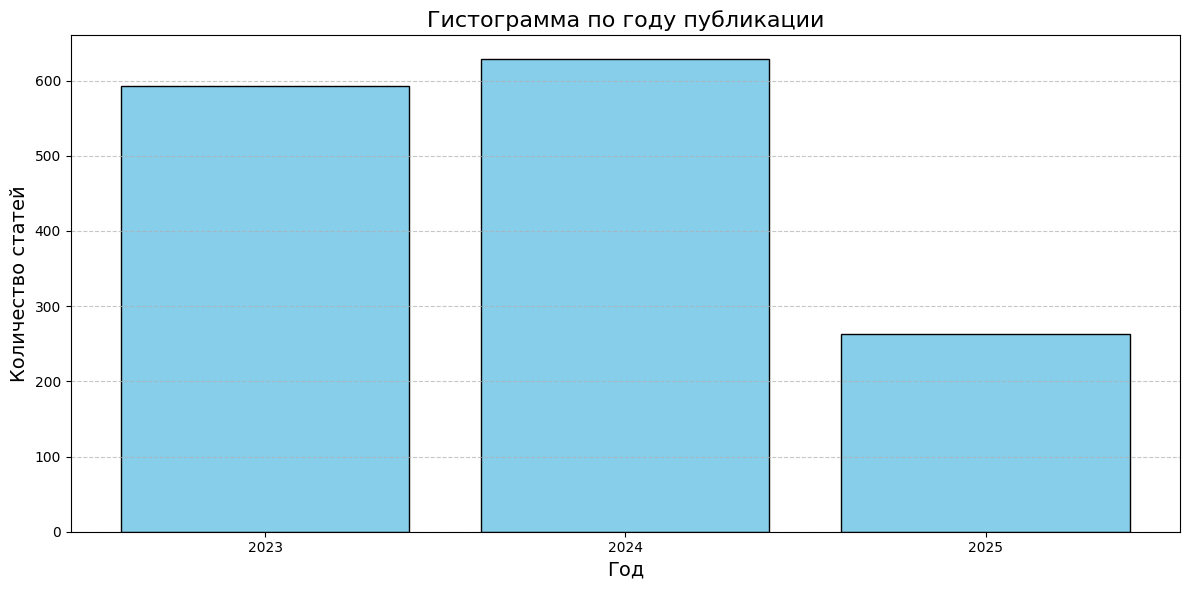

In [6]:
df_years = df.dropna(subset=['year']).copy()
df_years['year'] = df_years['year'].astype(int)

year_counts = df_years['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(year_counts.index, year_counts.values, color='skyblue', edgecolor='black')
plt.title('Гистограмма по году публикации', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество статей', fontsize=14)
plt.xticks(year_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Рубрики

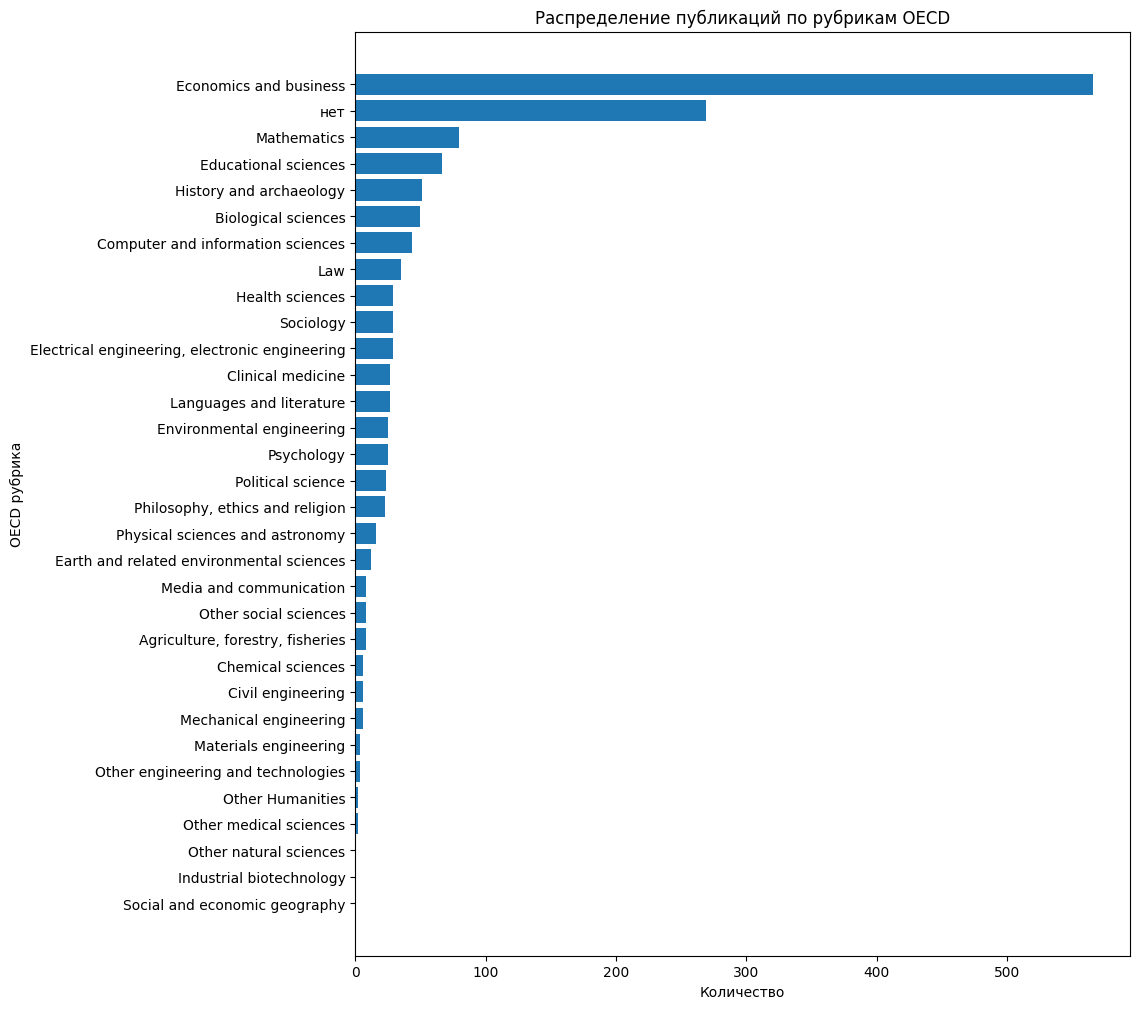

In [7]:
#df['OECD_lower'] = df['OECD'].str.lower()
#TRANSLATION_DICT_lower = {k.lower(): v for k, v in TRANSLATION_DICT.items()}
#df['OECD_ru'] = df['OECD_lower'].map(TRANSLATION_DICT_lower).fillna(df['OECD_lower'])

counts = df['OECD'].value_counts()
#counts = counts[counts.index != 'нет']       
counts = counts.sort_values(ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(counts.index, counts.values)
plt.xlabel("Количество")
plt.ylabel("OECD рубрика")
plt.title("Распределение публикаций по рубрикам OECD")
plt.show()


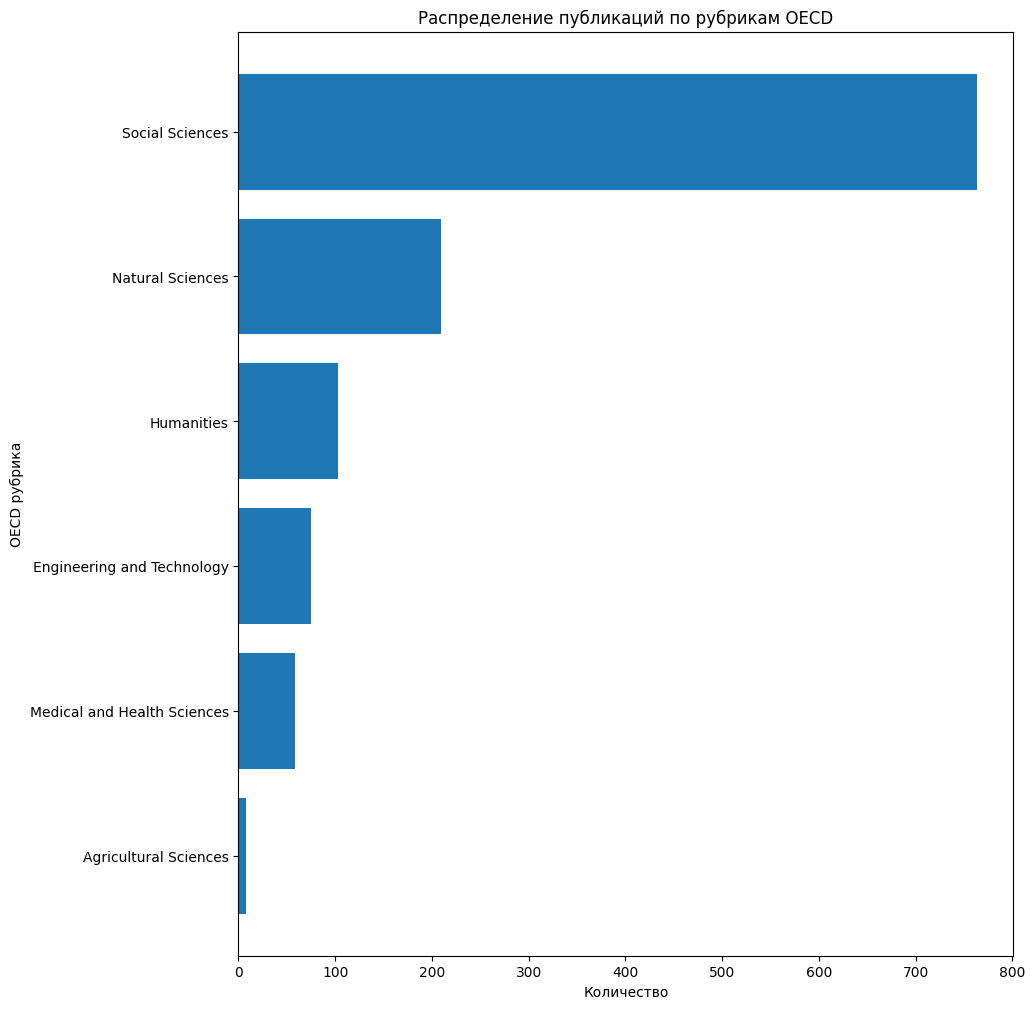

In [8]:
sub_to_first = {}
for first_level, subcategories in FIRST_LEVEL.items():
    for sub in subcategories:
        sub_to_first[sub.lower()] = first_level

def map_first_level(oecd_value):
    if pd.isna(oecd_value):
        return None
    return sub_to_first.get(oecd_value.lower(), None)  

df['first_OECD'] = df['OECD'].apply(map_first_level)

counts = df['first_OECD'].value_counts()     
counts = counts.sort_values(ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(counts.index, counts.values)
plt.xlabel("Количество")
plt.ylabel("OECD рубрика")
plt.title("Распределение публикаций по рубрикам OECD")
plt.show()


In [10]:
df['first_OECD'].value_counts()

first_OECD
Social Sciences                763
Natural Sciences               209
Humanities                     103
Engineering and Technology      75
Medical and Health Sciences     58
Agricultural Sciences            8
Name: count, dtype: int64

#### Цитирования

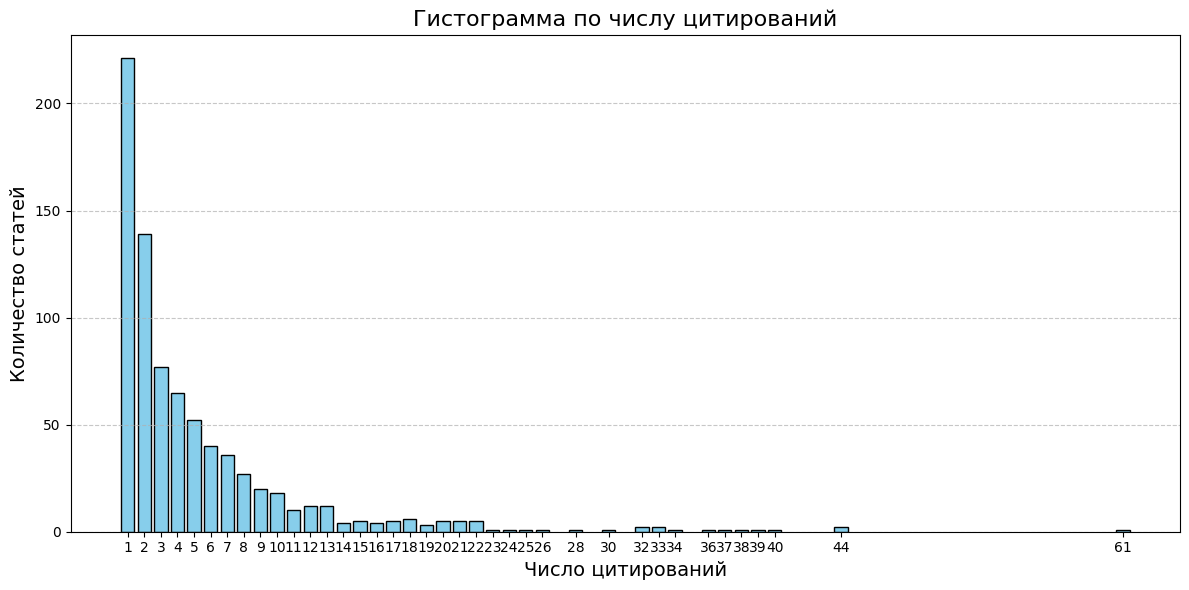

In [11]:
df_c = df.dropna(subset=['Цитирования']).copy()
df_c['Цитирования'] = df_c['Цитирования'].astype(int)
df_c = df_c[df_c['Цитирования'] > 0]  
df_c = df_c[df_c['Цитирования'] < 100]

citation_counts = df_c['Цитирования'].value_counts().sort_index()


plt.figure(figsize=(12, 6))
plt.bar(citation_counts.index, citation_counts.values, color='skyblue', edgecolor='black')
plt.title('Гистограмма по числу цитирований', fontsize=16)
plt.xlabel('Число цитирований', fontsize=14)
plt.ylabel('Количество статей', fontsize=14)
plt.xticks(citation_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Ключевые слова

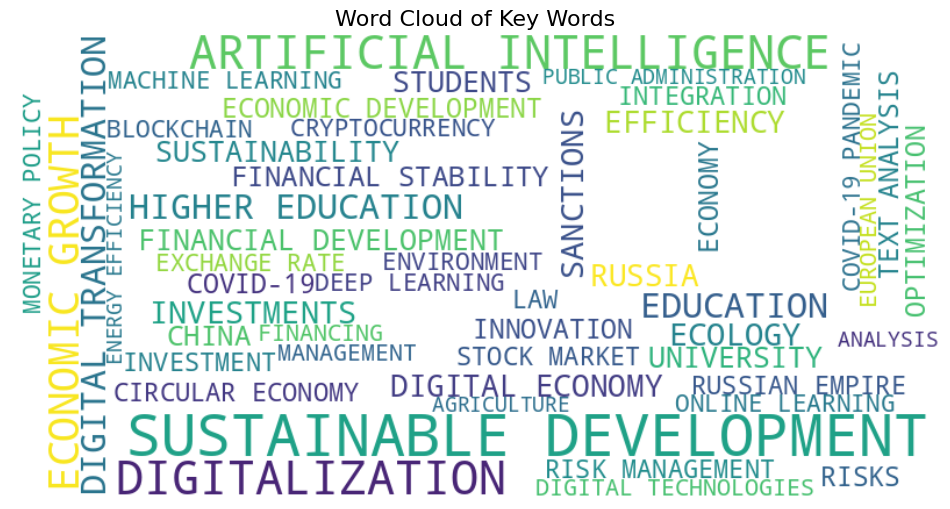

In [12]:
df_key = df.dropna(subset=['key_words_en']).copy()
df_key['key_words_en'] = df_key['key_words_en'].apply(literal_eval)

all_words = [word for sublist in df_key['key_words_en'] for word in sublist]

word_counts = Counter(all_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',  
    max_words=50         
).generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Key Words', fontsize=16)
plt.show()

#### Журналы

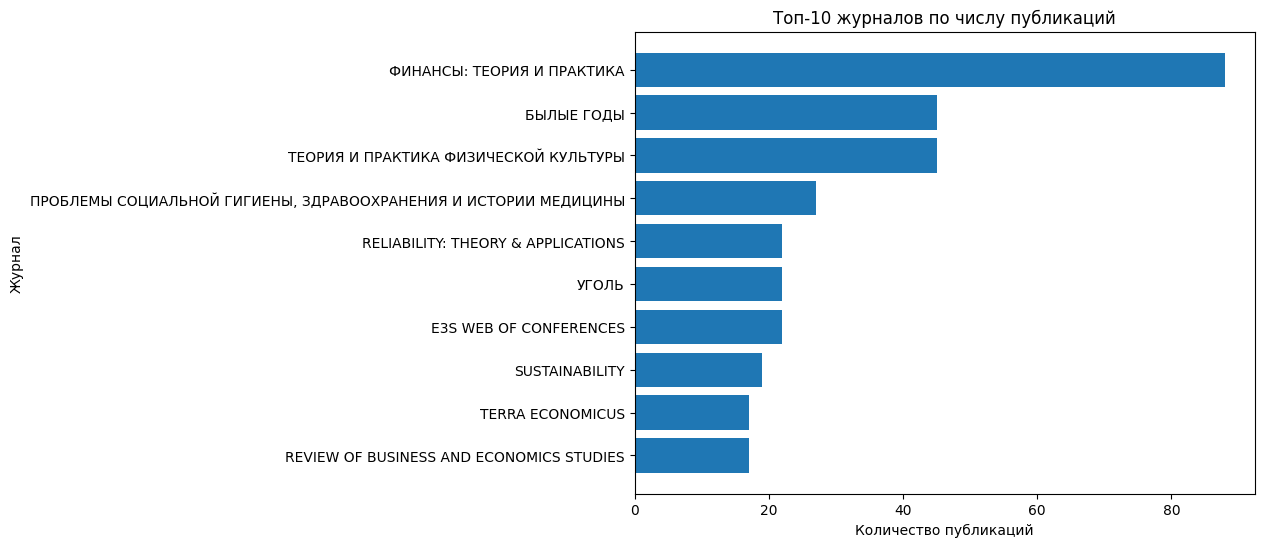

In [34]:
df_journals = df.dropna(subset=['Название журнала'])

top_journals_count = df_journals['Название журнала'].value_counts().head(10)
    
counts = top_journals_count.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(counts.index, counts.values)
plt.xlabel('Количество публикаций')
plt.ylabel('Журнал')
plt.title('Топ-10 журналов по числу публикаций')
plt.show()

